In [1]:
import atmosphere as atmo
import aerodynamics as aero
import rocket_parser as rp
import matplotlib.pyplot as plt
import ballistics


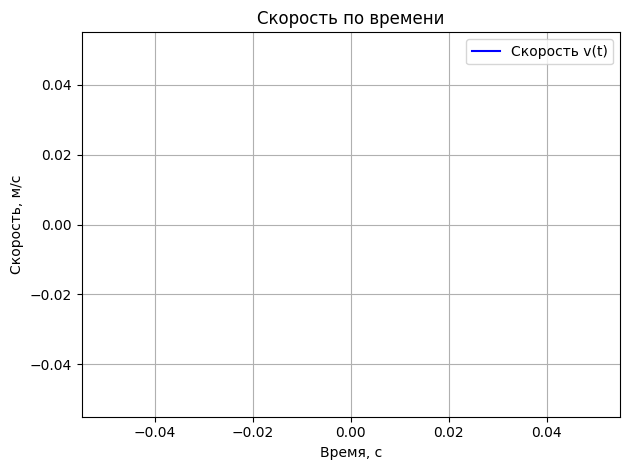

In [2]:
plt.plot(ballistics.time_list, ballistics.vel_list, label='Скорость v(t)', color='blue')
plt.xlabel('Время, с')
plt.ylabel('Скорость, м/с')
plt.title('Скорость по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

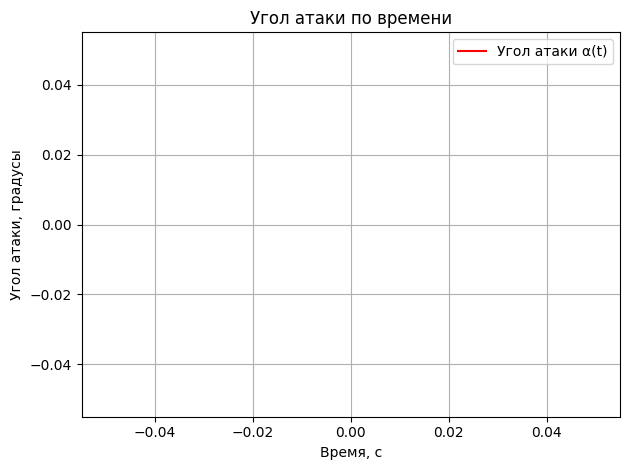

In [3]:
plt.plot(ballistics.time_list, ballistics.attack_list, label='Угол атаки α(t)', color='red')
plt.xlabel('Время, с')
plt.ylabel('Угол атаки, градусы')
plt.title('Угол атаки по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

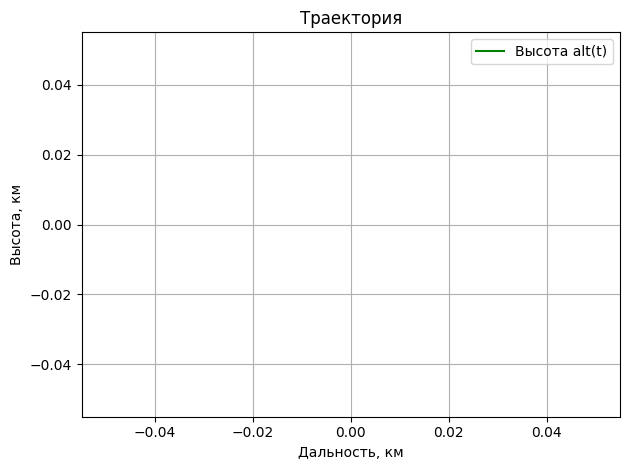

In [4]:
plt.plot(ballistics.long_list, ballistics.alt_list, label='Высота alt(t)', color='green')
plt.xlabel('Дальность, км')
plt.ylabel('Высота, км')
plt.title('Траектория')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

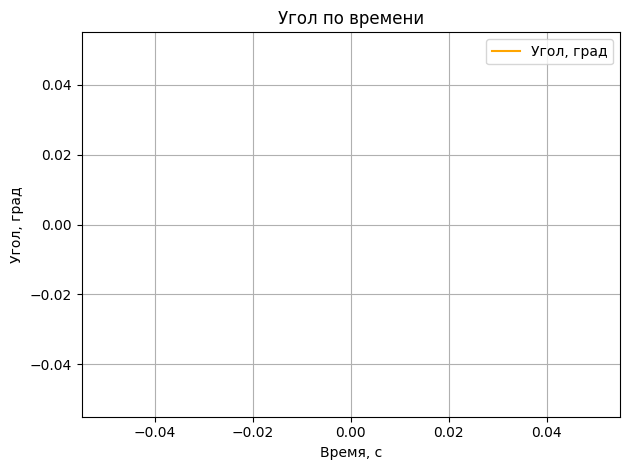

In [5]:
plt.plot(ballistics.time_list, ballistics.traj_list, label='Угол, град', color='orange')
plt.xlabel('Время, с')
plt.ylabel('Угол, град')
plt.title('Угол по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()